# Projet Classification images

Dans ce projet, nous allons procéder à la présentation d'un projet de classification d'images.

Le jeu de données provient du site Kaggle et correspond à une classification concernant la pneumonie.

Notre rôle sera d'analyser les images puis de procéder à une classification d'images.

Pour procéder à cette étape, nous allons prendre la décision d'utiliser le Transfer Learning avec 2 modèles : le RESNET50 et le MobileNetV2;

Bien entendu, notre jeu de données contient un faible nombre d'images (environ 5900), il faut prendre en note cette information qui peut fortement impacter notre analyse.
En effet, l'utilisation d'un réseau de neurones (Deep Learning) est davantage adapté à un très grand jeu de données.

Lien URL du jeu de données : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

# Sommaire

## I. Importation
### 1. Importation des bibliothèques
### 2. Importation des fichiers

## II. Exploration des données

## III. Modélisation
### 1. RESNET50
### 2. MobileNetV2

## I. Importation

### 1. Importation des bibliothèques

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img


import warnings
warnings.filterwarnings('ignore')

### 2. Importation des fichiers

In [2]:
# Chemin du dossier contenant les trois sous-dossiers (train, val et test)
chemin_principal = "C:/Users/gregm/OneDrive/Bureau/Projet perso/Classification image"

# Dictionnaire pour stocker le nombre d'images par dossier
nombre_images_par_dossier = {}

# Fonction récursive pour compter les images dans un dossier donné
def compter_images_dossier(chemin_dossier):
    total_images = 0
    for root, _, fichiers in os.walk(chemin_dossier):
        for fichier in fichiers:
            if fichier.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                total_images += 1
    return total_images

# Parcourir les sous-dossiers (train, val et test)
for dossier in ["train", "val", "test"]:
    chemin_dossier = os.path.join(chemin_principal, dossier)
    
    # Vérifier si le dossier existe
    if os.path.exists(chemin_dossier):
        # Appeler la fonction récursive pour compter les images
        nombre_images_par_dossier[dossier] = compter_images_dossier(chemin_dossier)
    else:
        nombre_images_par_dossier[dossier] = 0

# Afficher le nombre d'images par dossier
for dossier, nombre_images in nombre_images_par_dossier.items():
    print(f"Dossier '{dossier}': {nombre_images} images")


Dossier 'train': 5216 images
Dossier 'val': 16 images
Dossier 'test': 624 images


In [3]:
# Define image size and other parameters
img_width, img_height = 256, 256
batchsize = 32
epochs = 10
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory="C:/Users/gregm/OneDrive/Bureau/Projet perso/Classification image/train",
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory="C:/Users/gregm/OneDrive/Bureau/Projet perso/Classification image/val",
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory="C:/Users/gregm/OneDrive/Bureau/Projet perso/Classification image/test",
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


Nos données sont à présents prêtes, nous avons pu importé l'ensemble de notre jeu de données.

Nous allons pouvoir procéder à une exploration de nos données avant de passer à l'étape de modélisation.

# 

## II. Exploration des données

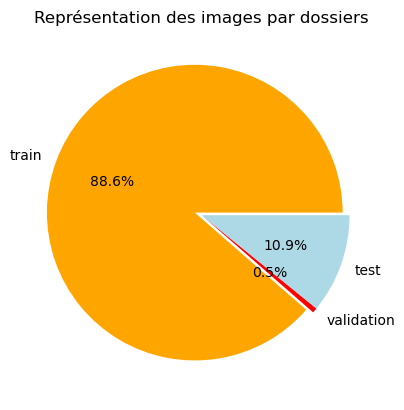

In [4]:
plt.pie([len(train), len(validation), len(test)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.title('Représentation des images par dossiers')
plt.show()

In [5]:
print(train.class_names)
print(validation.class_names)
print(test.class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


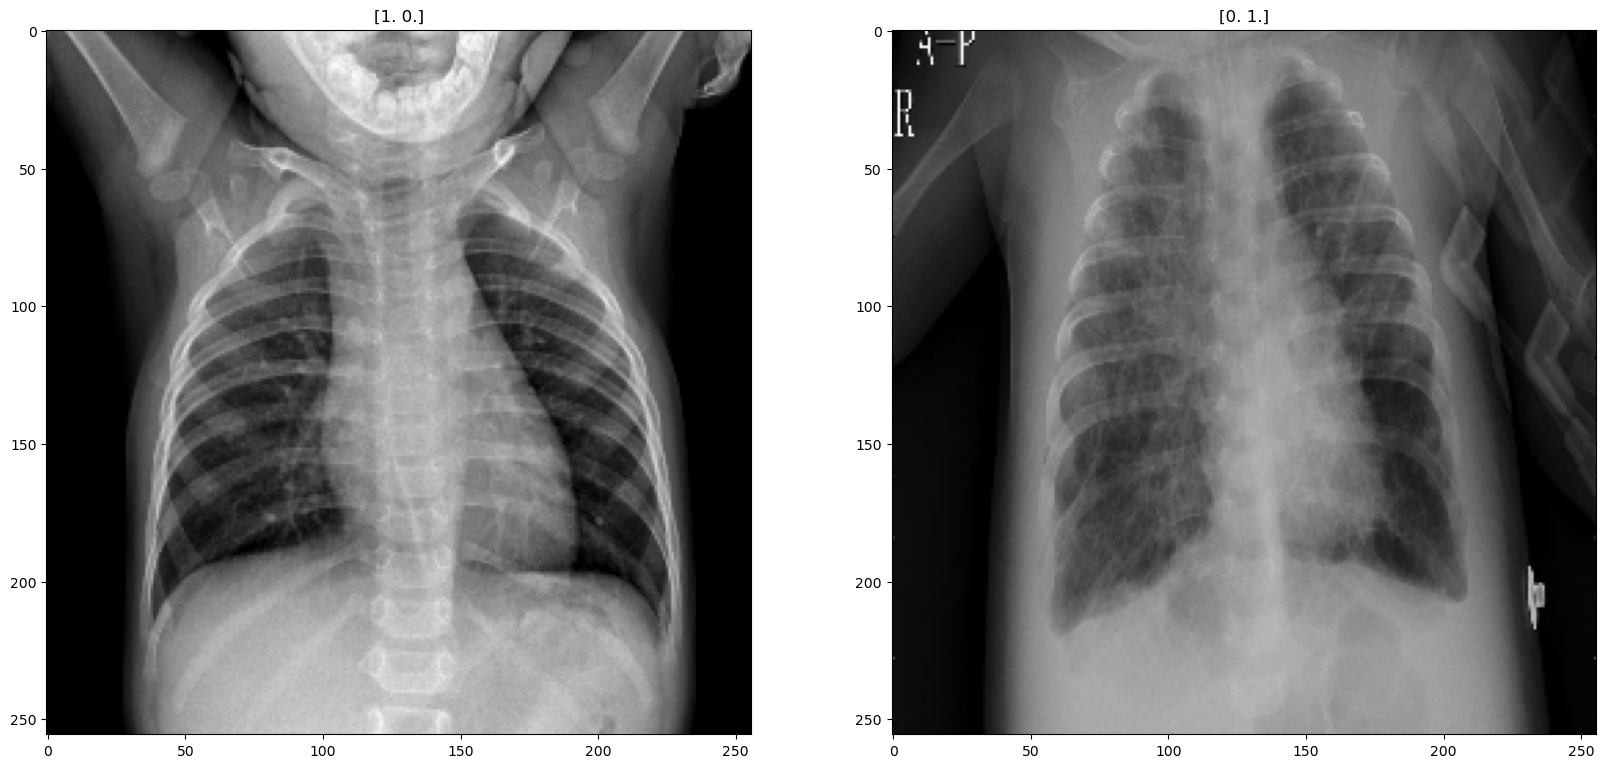

In [6]:
# Visualisation 2 images dans le dossier train

data_train = train.as_numpy_iterator()
batch = data_train.next()
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
for idx, img in enumerate(batch[0][:2]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

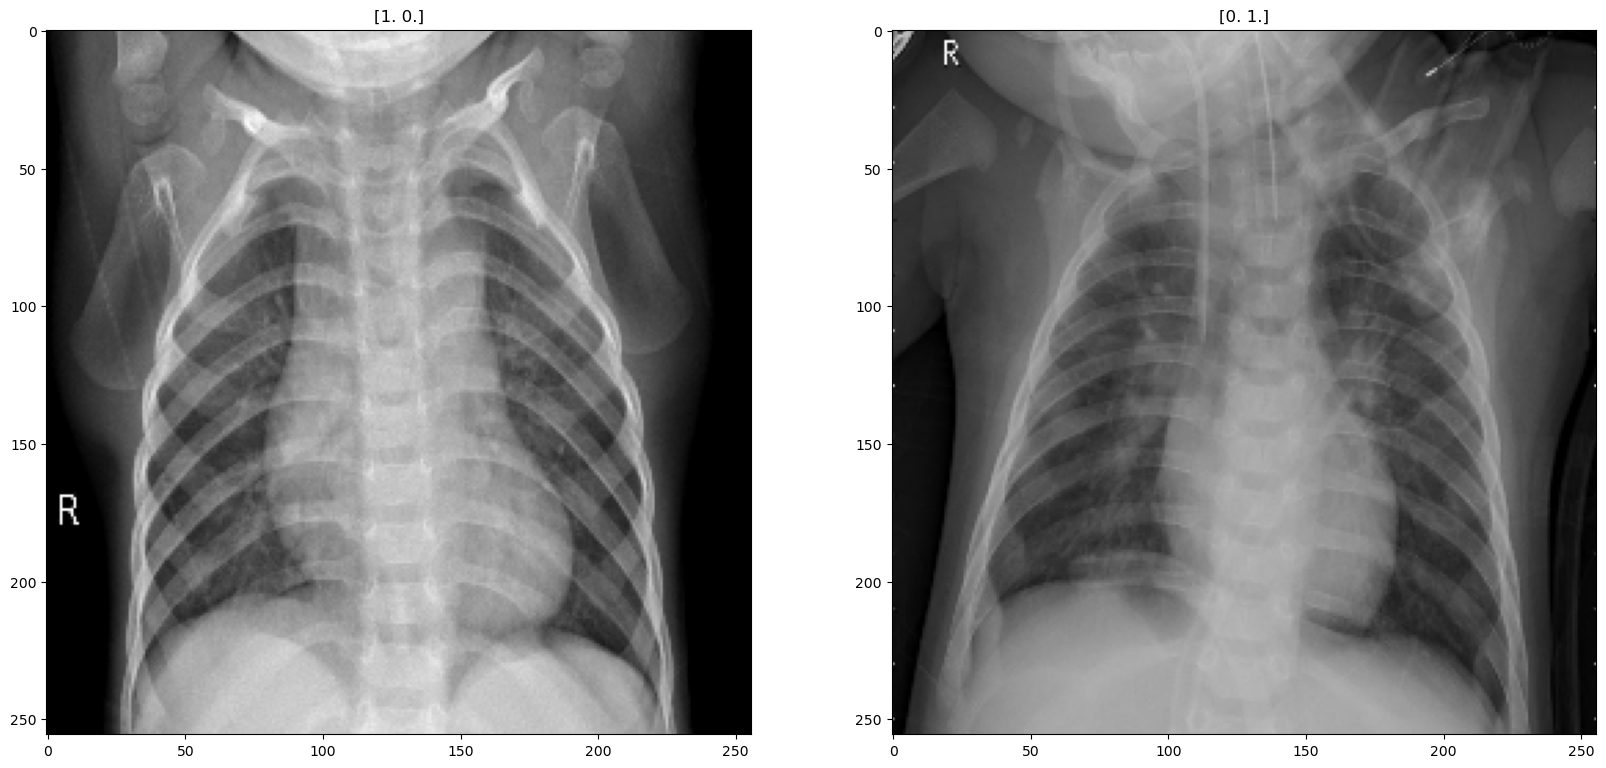

In [7]:
# Visualisation 2 images dans le dossier test

data_test = test.as_numpy_iterator()
batch = data_test.next()
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
for idx, img in enumerate(batch[0][:2]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

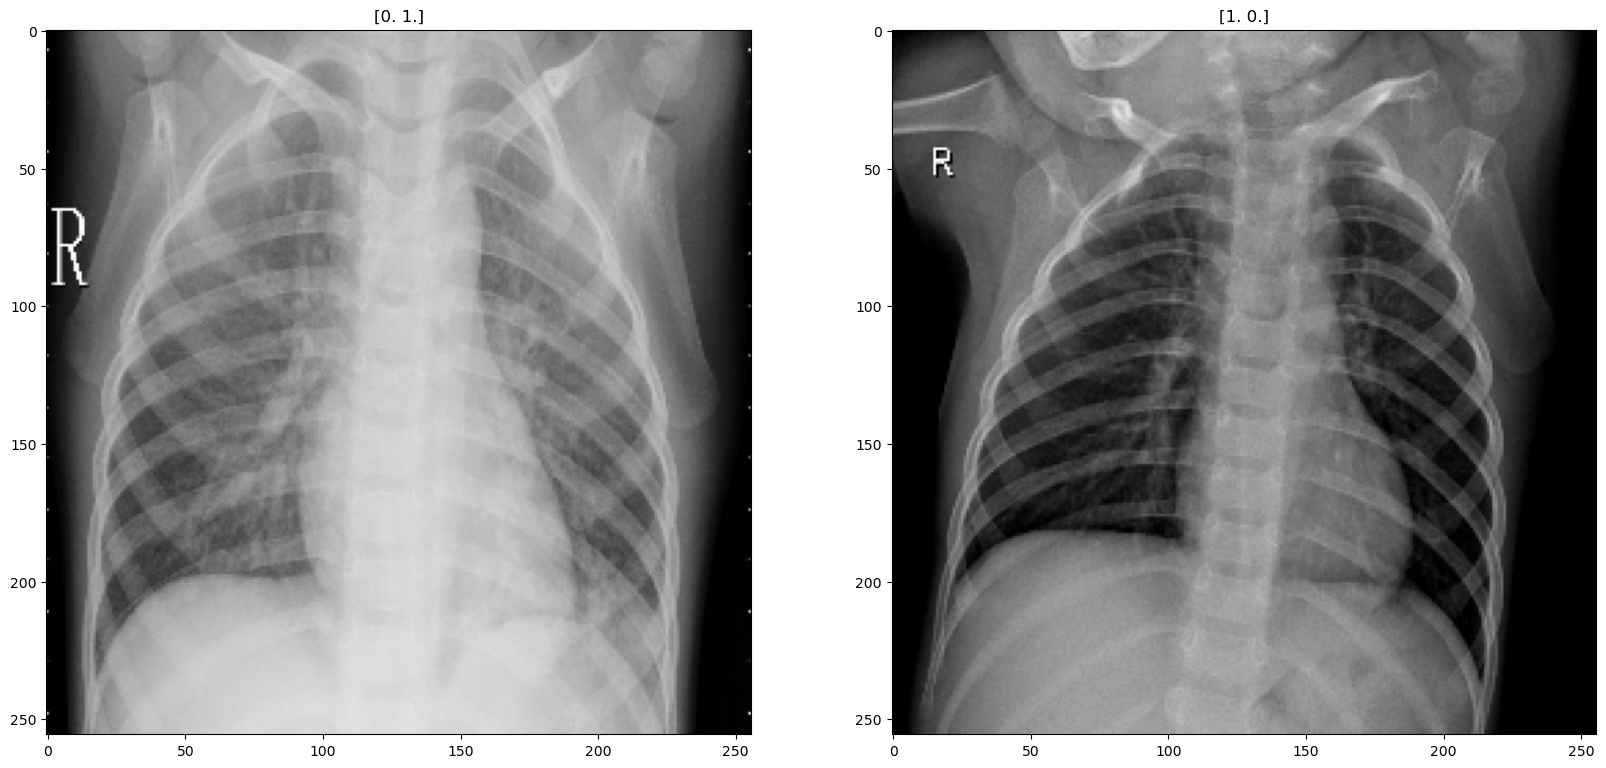

In [8]:
# Visualisation 2 images dans le dossier val

data_val = validation.as_numpy_iterator()
batch = data_val.next()
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
for idx, img in enumerate(batch[0][:2]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [9]:
# Extraction features et des labels

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature.numpy())
    y_train.append(label.numpy())

for feature, label in test:
    x_test.append(feature.numpy())
    y_test.append(label.numpy())
    
for feature, label in validation:
    x_val.append(feature.numpy())
    y_val.append(label.numpy())

# Concaténation des valeurs
x_train = np.concatenate(x_train, axis=0)
x_val = np.concatenate(x_val, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_val = np.concatenate(y_val, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [10]:
# Utilisation du shape :
print("Shape of 'x_train':", x_train.shape)
print("Shape of 'y_train':", y_train.shape)
print("Shape of 'x_val':", x_val.shape)
print("Shape of 'y_val':", y_val.shape)
print("Shape of 'x_test':", x_test.shape)
print("Shape of 'y_test':", y_test.shape)

Shape of 'x_train': (5216, 256, 256, 3)
Shape of 'y_train': (5216, 2)
Shape of 'x_val': (16, 256, 256, 3)
Shape of 'y_val': (16, 2)
Shape of 'x_test': (624, 256, 256, 3)
Shape of 'y_test': (624, 2)


In [11]:
# Normalisation des données
x_train=x_train/256
x_val=x_val/256
x_test=x_test/256

## III. Modélisation

###### Exemple Réseau CNN

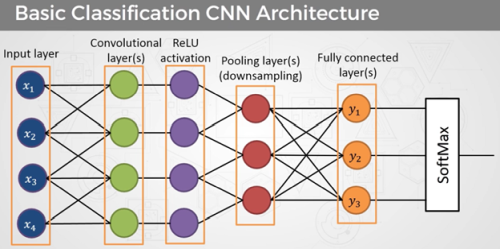

### 1.RESNET50

In [12]:
# Importer les librairies nécessaires
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras

# Utilisation du modèle ResNet-50
def CNN_Model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2 - i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height, 3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Compilation du modèle et entrainement
model = CNN_Model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  
# Visualisation des couches du CNN
keras.utils.plot_model(model, show_shapes=True)

hist = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val))
print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Le meilleur score de validation est : {best_score}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 40365314 (153.98 MB)
Trainable params: 178

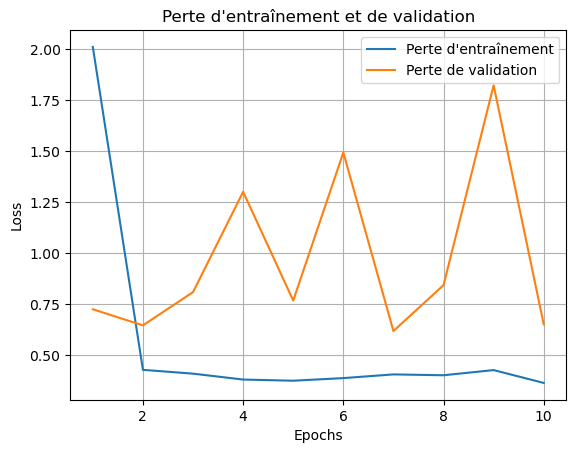

In [14]:
# Extraction données entrainement et validation
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Création liste d'epochs
epochs = range(1, len(train_loss) + 1)

# Traçage du graphique
plt.plot(epochs, train_loss, label="Perte d'entraînement")
plt.plot(epochs, val_loss, label='Perte de validation')
plt.title("Perte d'entraînement et de validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

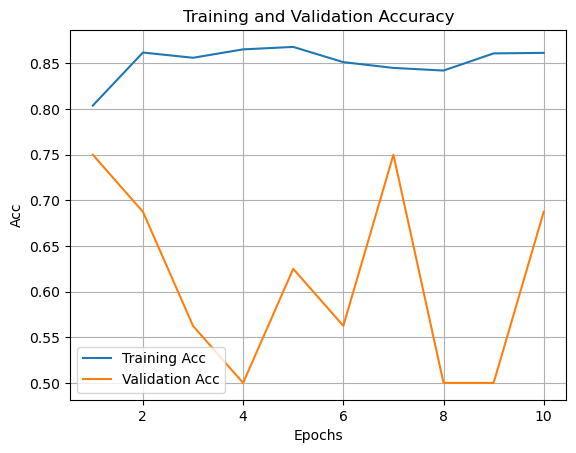

In [15]:
# Extraire les valeurs de perte d'entraînement et de validation à partir de l'objet d'historique
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Création liste d'epochs
epochs = range(1, len(train_accuracy) + 1)

# Traçage du graphique de perte
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

Nous pouvons constater que notre modèle a présenté de très bons résultats dans le cadre de l'entrainement.
Toutefois, la non mise en place d'un EarlyStop peut provoquer un entrainement supplémentaire pouvant provoquer de l'overfitting ou de l'underfitting.

Notre premier modèle présente une durée d'entrainement très élevée, ce dernier va demander un nombre de données plus élevés.

Nous allons, à présent, procéder à un entrainement avec un autre modèle mais avec la mise en place d'un EarlyStop.

In [16]:
# Création du Early Stop
early_stop = EarlyStopping(monitor='val_loss',patience=3)

# Définir le nombre d'itérations d'entraînement
epochs = 20

### 2. Modèle MobileNetV2

In [17]:
# Utilisation du MobileNETV2


def CNN_Model():
    base_model = MobileNetV2(weights='imagenet', include_top = False, input_shape=(img_width, img_height, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(img_width, img_height,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dropout(0.3))
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(2, activation='sigmoid'))
    
    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()  


hist = model.fit(x_train, y_train,
                 epochs= epochs,
                 validation_data= (x_val, y_val),
                 callbacks=[early_stop])


print(hist.history)
best_score = max(hist.history['val_accuracy'])
print(f"Best Validation score is: {best_score}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dropout_2 (Dropout)         (None, 81920)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               10485888  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                      

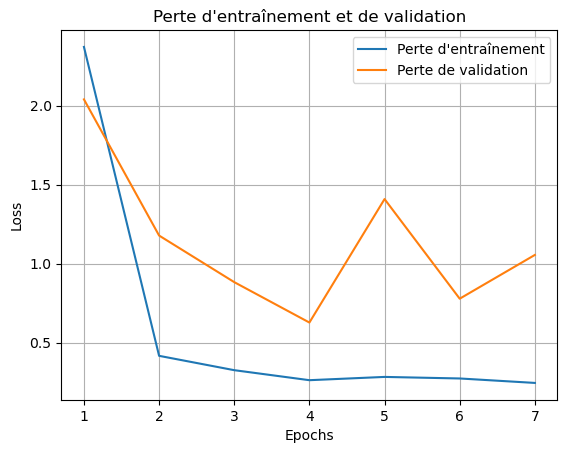

In [18]:
# Extraction données entrainement et validation
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Création liste d'epochs
epochs = range(1, len(train_loss) + 1)

# Traçage du graphique
plt.plot(epochs, train_loss, label="Perte d'entraînement")
plt.plot(epochs, val_loss, label='Perte de validation')
plt.title("Perte d'entraînement et de validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

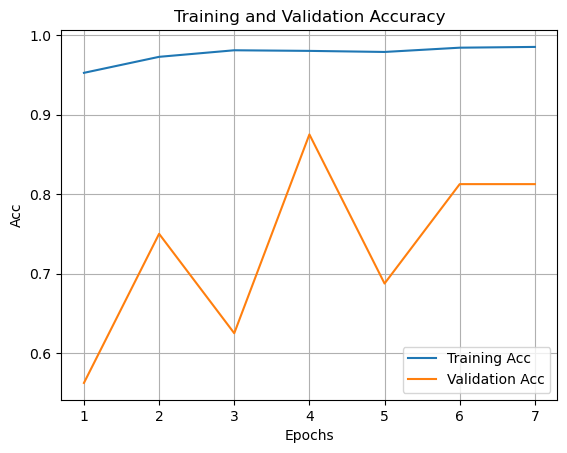

In [19]:
# Extraire les valeurs de perte d'entraînement et de validation à partir de l'objet d'historique
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Création liste d'epochs
epochs = range(1, len(train_accuracy) + 1)

# Traçage du graphique de perte
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

Notre second modèle a obtenu de très bons résultats avec un score de 0.98. L'utilisation d'un EarlyStop nous a permis d'interrompre et d'éviter un entrainement peu utile.

Ce modèle semble être le plus cohérent dans notre problématique de classification.

# Conclusion

En concluant notre étude sur la classification d'images, nous pouvons affirmer avec confiance que nous avons atteint notre objectif initial en élaborant une approche efficace pour cette tâche complexe. Notre démarche a été marquée par plusieurs étapes clés, et les résultats obtenus reflètent l'efficacité de notre méthodologie.

Tout d'abord, nous avons consacré une attention particulière à la préparation minutieuse des données. Cette étape cruciale a permis de garantir la qualité et la cohérence de notre jeu de données, créant ainsi une base solide pour l'entraînement de nos modèles.

Dans notre premier essai, nous avons opté pour l'utilisation d'un modèle ResNet-50, qui a montré des performances prometteuses dès le départ. Cette approche nous a donné des résultats satisfaisants, mais notre quête d'excellence nous a poussés à explorer davantage.

C'est à ce stade que nous avons introduit une stratégie intelligente pour améliorer encore nos résultats. Nous avons mis en place un mécanisme d'arrêt anticipé (EarlyStop) afin d'éviter le surapprentissage et d'optimiser l'efficacité de notre modèle. Cette décision s'est avérée judicieuse, car elle a contribué à stabiliser nos performances et à garantir que notre modèle généralise bien sur de nouvelles données.

Enfin, notre expérience avec l'utilisation de MobileNetV2 a constitué un tournant significatif. Ce modèle a surclassé nos attentes en obtenant des résultats encore meilleurs que ceux de ResNet-50. Ce changement de modèle a démontré la flexibilité de notre approche et notre capacité à choisir des architectures de modèles adaptées à notre tâche spécifique.

Il est important de souligner que notre démarche n'est qu'une illustration parmi de nombreuses autres possibilités. Il existe une vaste gamme de modèles de deep learning disponibles, chacun offrant des avantages uniques pour des tâches de classification d'images. Notre étude met en lumière la méthodologie du transfert d'apprentissage (Transfer Learning) comme une approche puissante pour cette tâche, mais elle n'épuise pas les alternatives possibles.

En somme, notre exploration de la classification d'images a été une expérience enrichissante, non seulement pour les résultats obtenus, mais aussi pour la méthodologie rigoureuse que nous avons suivie. Nous espérons que cette étude servira de base solide pour d'autres chercheurs et praticiens désireux d'aborder des tâches similaires en utilisant des techniques de deep learning, tout en gardant à l'esprit que l'univers de la classification d'images regorge d'opportunités à explorer.